Dataset columns: Index(['Date', 'series', 'OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'ltp', 'close',
       'vwap', '52W H', '52W L', 'VOLUME', 'VALUE', 'No of trades'],
      dtype='object')
Epoch 1/100


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2696
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0474
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0261
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0244
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0231
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0164
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0193
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0137
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0132
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0178
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0127
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0142
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0144
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0129
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0152
E

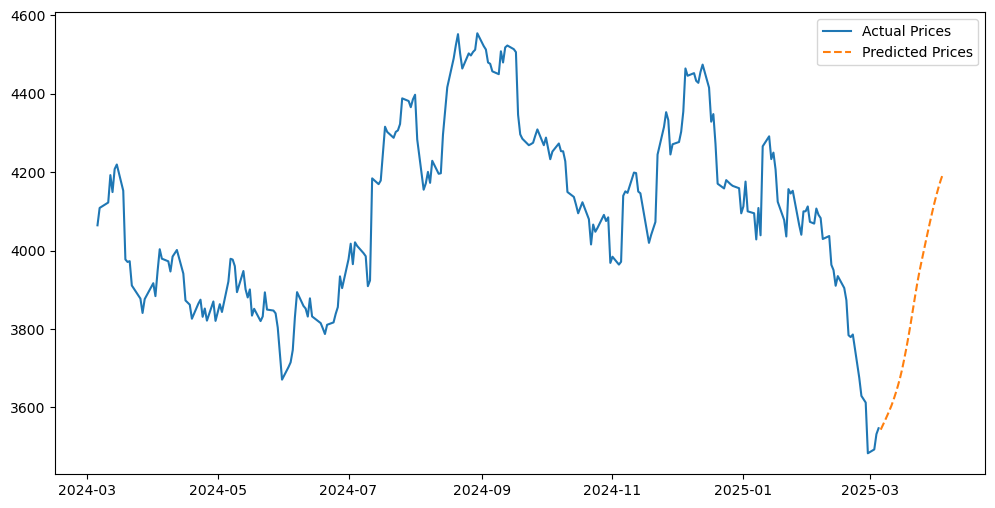

Next 30 days predicted prices:
[3543.394  3555.0989 3566.8086 3579.0566 3591.5413 3604.7925 3619.928
 3636.7605 3654.968  3675.095  3698.0151 3724.7573 3752.7502 3783.0037
 3815.2683 3849.3284 3883.0984 3915.866  3945.2773 3971.7173 3997.5205
 4023.5288 4048.7922 4073.5337 4097.6973 4120.876  4142.277  4162.033
 4179.929  4195.828 ]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the dataset
df = pd.read_csv("Quote-Equity-TCS-EQ-06-03-2024-to-06-03-2025.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Print column names to check their actual format
print("Dataset columns:", df.columns)

# Convert 'Date' to datetime and sort
df['Date'] = pd.to_datetime(df['Date'], format="%d-%b-%Y")
df = df.sort_values(by='Date')

# Ensure 'close' column exists
if 'close' not in df.columns:
    raise KeyError("close column not found in the dataset")

# Normalize only 'close' column
scaler = MinMaxScaler(feature_range=(0, 1))
df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)
df_scaled = scaler.fit_transform(df[['close']])

def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step, 0])  # Predicting 'close' price
    return np.array(X), np.array(y)

# Prepare data
time_step = min(60, len(df_scaled) - 1)  # Adjust time_step dynamically if data is small
X, y = create_sequences(df_scaled, time_step)

# Ensure X and y are not empty before reshaping
if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("Insufficient data to create sequences. Try reducing time_step.")

X = X.reshape(X.shape[0], X.shape[1], 1)

# Define LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=100, batch_size=16, verbose=1)

# Predict next 30 days
future_inputs = df_scaled[-time_step:].reshape(1, time_step, 1)
future_predictions = []
for _ in range(30):
    pred = model.predict(future_inputs)[0, 0]
    future_predictions.append(pred)
    future_inputs = np.roll(future_inputs, -1, axis=1)
    future_inputs[0, -1, 0] = pred  # Update the last timestep

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['close'], label='Actual Prices')
pred_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)
plt.plot(pred_dates, future_predictions, label='Predicted Prices', linestyle='dashed')
plt.legend()
plt.show()

# Print predictions
print("Next 30 days predicted prices:")
print(future_predictions.flatten())


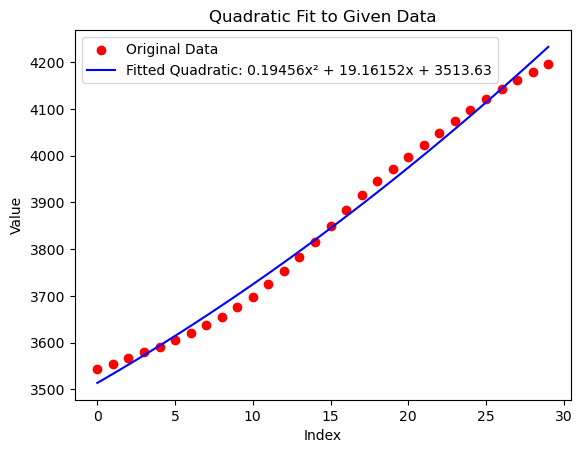

array([1.94564714e-01, 1.91615219e+01, 3.51362593e+03])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Given data points
x = np.arange(len([3543.394, 3555.0989, 3566.8086, 3579.0566, 3591.5413, 3604.7925, 3619.928,
                   3636.7605, 3654.968, 3675.095, 3698.0151, 3724.7573, 3752.7502, 3783.0037,
                   3815.2683, 3849.3284, 3883.0984, 3915.866, 3945.2773, 3971.7173, 3997.5205,
                   4023.5288, 4048.7922, 4073.5337, 4097.6973, 4120.876, 4142.277, 4162.033,
                   4179.929, 4195.828]))
y = np.array([3543.394, 3555.0989, 3566.8086, 3579.0566, 3591.5413, 3604.7925, 3619.928,
              3636.7605, 3654.968, 3675.095, 3698.0151, 3724.7573, 3752.7502, 3783.0037,
              3815.2683, 3849.3284, 3883.0984, 3915.866, 3945.2773, 3971.7173, 3997.5205,
              4023.5288, 4048.7922, 4073.5337, 4097.6973, 4120.876, 4142.277, 4162.033,
              4179.929, 4195.828])

# Define a quadratic function for fitting
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

# Fit the quadratic function to the data
params, _ = curve_fit(quadratic, x, y)

# Generate fitted values
x_fit = np.linspace(min(x), max(x), 100)
y_fit = quadratic(x_fit, *params)

# Plot the data and the fitted curve
plt.scatter(x, y, label="Original Data", color="red")
plt.plot(x_fit, y_fit, label=f"Fitted Quadratic: {params[0]:.5f}x² + {params[1]:.5f}x + {params[2]:.2f}", color="blue")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.title("Quadratic Fit to Given Data")
plt.show()

# Display the fitted quadratic equation parameters
params
